In [1]:
import os

print("File location using os.getcwd():", os.getcwd())

File location using os.getcwd(): C:\Users\91707\Downloads\Yelp-JSON\Yelp-BI-System\notebook


## Data Ingestion Layer: Reading Raw Yelp Web Data
In this section, we design a custom data ingestion module to handle large-scale, semi-structured web data from Yelp.  
The Yelp dataset is provided as JSON objects stored line-by-line in files. We build a dedicated loader class to:

- Read raw data efficiently from disk  
- Handle large files using streaming (line-by-line parsing)  
- Separate business data and review data  
- Act as the entry point of our analytics system  

In [2]:
import sys
import json

class YelpDataLoader:
    def __init__(self, business_path, review_path):
        self.business_path = business_path
        self.review_path = review_path
        self.businesses = []
        self.reviews = []

    def load_businesses(self, limit=None):
        with open(self.business_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if limit and i >= limit:
                    break
                self.businesses.append(json.loads(line))
        return self.businesses

    def load_reviews(self, limit=None):
        with open(self.review_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if limit and i >= limit:
                    break
                self.reviews.append(json.loads(line))
        return self.reviews


In [3]:
sys.path.append(os.path.abspath('../src'))

In [4]:
os.getcwd()
os.listdir("..")
os.listdir("../data")
os.listdir("../data/raw")

['yelp_academic_dataset_business.json', 'yelp_academic_dataset_review.json']

## Executing the Ingestion Pipeline and Filtering Restaurant Data
In this step, we instantiate the data ingestion module and load raw Yelp business and review data into memory.  
Since our business problem focuses on restaurants, we apply a domain-specific filter to retain only restaurant-related businesses.


In [5]:
from data_loader import YelpDataLoader

loader = YelpDataLoader(
    #Using relative paths to ensure portability and reproducibility
    business_path=r"../data/raw/yelp_academic_dataset_business.json",
    review_path=r"../data/raw/yelp_academic_dataset_review.json"
)

businesses = loader.load_businesses(limit=5000)
reviews = loader.load_reviews(limit=10000)

print("Businesses:", len(businesses))
print("Reviews:", len(reviews))
print(businesses[0].keys())
print(reviews[0].keys())

restaurants = loader.filter_restaurants()
len(restaurants)

Businesses: 5000
Reviews: 10000
dict_keys(['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours'])
dict_keys(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date'])


1762

## Object Construction Layer: Converting Raw Data into Business Entities
Raw JSON records are difficult to manage directly in large analytical systems.  
To introduce structure and modularity, we convert raw dictionaries into well-defined Business and Review objects.

This object construction layer enables:
- Encapsulation of business logic  
- Cleaner downstream analytics  
- Clear separation between raw data and analytical models  

In [6]:
from models import Business, Review

# Convert raw business dictionaries into structured Business objects
business_objects = []

# Each Business object encapsulates attributes and behavior of a restaurant
for b in restaurants:
    business_objects.append(
        Business(
            b["business_id"], # Unique business identifier (primary key)
            b["name"],
            b["city"],
            b["stars"],
            b["review_count"],
            b["categories"],
            b["attributes"]
        )
    )

# Convert raw review dictionaries into structured Review objects
review_objects = []
for r in reviews:
    review_objects.append(
        Review(
            r["review_id"], # Unique review identifier
            r["business_id"], # Foreign key linking review to a business
            r["stars"],
            r["text"],
            r["useful"]
        )
    )

len(business_objects), len(review_objects)


(1762, 10000)

## Database Layer: Persistent Storage and Relational Modeling
To enable structured storage, querying, and scalability, we persist the processed business and review data into a relational database.

We design and populate a SQLite database with separate tables for businesses and reviews, linked using primary–foreign key relationships.  

In [7]:
from database import YelpDatabase

# Initialize the database connection
db = YelpDatabase("../db/yelp.db")

# Create relational tables for businesses and reviews
db.create_tables()

# Insert structured Business and Review objects into the database
db.insert_businesses(business_objects)
db.insert_reviews(review_objects)

print("Database created and populated.")

Database created and populated.


In [8]:
#Check if database is created
os.listdir("../db")

['yelp.db']

In [9]:
#Displays top cities by average rating and number of businesses in each of these cities
db.top_cities_by_rating()


[('Spanish Springs', 5.0, 1),
 ('Maple Shade', 5.0, 1),
 ('Wimauma', 4.5, 1),
 ('Wesley Chapel', 4.5, 3),
 ('Virginia City', 4.5, 1),
 ('Valrico', 4.5, 1),
 ('Trooper', 4.5, 1),
 ('Trenton', 4.5, 2),
 ('Tarpon Springs', 4.5, 1),
 ('St.Ann', 4.5, 1)]

In [10]:
#Displays top categories by average rating and number of businesses in each of these cities
db.top_categories()

[('Vegetarian, Restaurants, Gluten-Free', 5.0, 1),
 ('Thai, Sushi Bars, Restaurants', 5.0, 1),
 ('Street Vendors, Food, Restaurants, Mexican, Food Stands', 5.0, 1),
 ('Steakhouses, Restaurants, Japanese, Sushi Bars', 5.0, 1),
 ('Soul Food, Vegan, Event Planning & Services, Restaurants, Caterers',
  5.0,
  1),
 ('Shaved Ice, Food Stands, Restaurants, Street Vendors, Food Trucks, Food, Desserts',
  5.0,
  1),
 ('Sandwiches, Food, Caribbean, Puerto Rican, Restaurants, Food Trucks',
  5.0,
  1),
 ('Salad, Restaurants, Vegetarian, Middle Eastern, Sandwiches, Mediterranean',
  5.0,
  1),
 ('Restaurants, Sushi Bars', 5.0, 1),
 ('Restaurants, Southern, Food Trucks, Food, Breakfast & Brunch, Desserts',
  5.0,
  1)]

In [11]:
db.rating_distribution()

[(1.0, 9),
 (1.5, 61),
 (2.0, 85),
 (2.5, 162),
 (3.0, 257),
 (3.5, 395),
 (4.0, 463),
 (4.5, 281),
 (5.0, 49)]

## Repository Layer: Internal Data Structures and Fast Access Engine
While the database ensures persistence, efficient analytics requires fast in-memory access and structured indexing.

We therefore build a Repository layer that:
- Organizes Business and Review objects
- Constructs hash-based indexes for fast lookup
- Groups reviews by business
- Acts as a centralized data access engine for all analytics modules

In [12]:
from repository import YelpRepository
repo = YelpRepository(business_objects, review_objects)

## Analytics Engine: Defining and Measuring Restaurant Success

After building the data infrastructure, we now introduce the core analytics engine.

The RestaurantSuccessAnalyzer encapsulates the business logic and algorithms used to:
- Quantify restaurant success
- Rank restaurants based on multi-dimensional metrics
- Support downstream market and strategy analysis


In [13]:
from analytics_engine import RestaurantSuccessAnalyzer

analyzer = RestaurantSuccessAnalyzer(repo)


In [14]:
analyzer.top_restaurants(10)

[(<models.Business at 0x1e230d23ef0>, 0.7799),
 (<models.Business at 0x1e230d22360>, 0.779),
 (<models.Business at 0x1e230d2c8c0>, 0.7649),
 (<models.Business at 0x1e230d406e0>, 0.7536),
 (<models.Business at 0x1e230d40dd0>, 0.7527),
 (<models.Business at 0x1e230d2c5f0>, 0.7464),
 (<models.Business at 0x1e230d2cb90>, 0.7455),
 (<models.Business at 0x1e230cee930>, 0.7416),
 (<models.Business at 0x1e230d3aa20>, 0.7409),
 (<models.Business at 0x1e230d0d2e0>, 0.7405)]

In [15]:
analyzer.city_performance()[:10]

[('Riverside', 5.0, 1),
 ('Collegeville', 5.0, 1),
 ('Newtown Square', 5.0, 1),
 ('Greenbrier', 5.0, 1),
 ('Greenville', 5.0, 1),
 ('Spanish Springs', 5.0, 1),
 ('Wesley Chapel', 4.5, 4),
 ('Virginia City', 4.5, 1),
 ('Haddon Heights', 4.5, 2),
 ('Mascoutah', 4.5, 1)]

In [16]:
analyzer.category_performance()[:10]

[('Party Equipment Rentals', 5.0, 1),
 ('Wine Tasting Classes', 5.0, 1),
 ('Education', 5.0, 1),
 ('Tasting Classes', 5.0, 1),
 ('Veterinarians', 5.0, 1),
 ('International Grocery', 5.0, 1),
 ('Pets', 4.83, 3),
 ('Pet Adoption', 4.75, 2),
 ('Shaved Ice', 4.75, 2),
 ('Vitamins & Supplements', 4.75, 2)]

In [17]:
top10 = analyzer.top_restaurants()

for b, score in top10:
    print(f"{b.name} | {b.city} |  {b.stars} | Reviews: {b.review_count} | Success Score: {score}")


Prep & Pastry | Tucson |  4.5 | Reviews: 2126 | Success Score: 0.7799
District Donuts Sliders Brew | New Orleans |  4.5 | Reviews: 2062 | Success Score: 0.779
Katie's Restaurant & Bar | New Orleans |  4.5 | Reviews: 1289 | Success Score: 0.7649
Padaro Beach Grill | Carpinteria |  4.5 | Reviews: 885 | Success Score: 0.7536
Luke | New Orleans |  4.0 | Reviews: 4554 | Success Score: 0.7527
Yah Mon | Tampa |  4.5 | Reviews: 697 | Success Score: 0.7464
Coffeebar | Reno |  4.5 | Reviews: 676 | Success Score: 0.7455
Mike's Ice Cream | Nashville |  4.5 | Reviews: 593 | Success Score: 0.7416
Kanella | Philadelphia |  4.5 | Reviews: 579 | Success Score: 0.7409
Blue Sage Vegetarian Grille | Southampton |  4.5 | Reviews: 572 | Success Score: 0.7405


## Visualization Layer

In [18]:
import matplotlib.pyplot as plt

We begin our analysis by understanding the broad landscape of the Yelp restaurant ecosystem.

This section focuses on high-level, descriptive analytics to identify:
- how restaurant performance varies geographically
- which cities tend to have higher average restaurant ratings

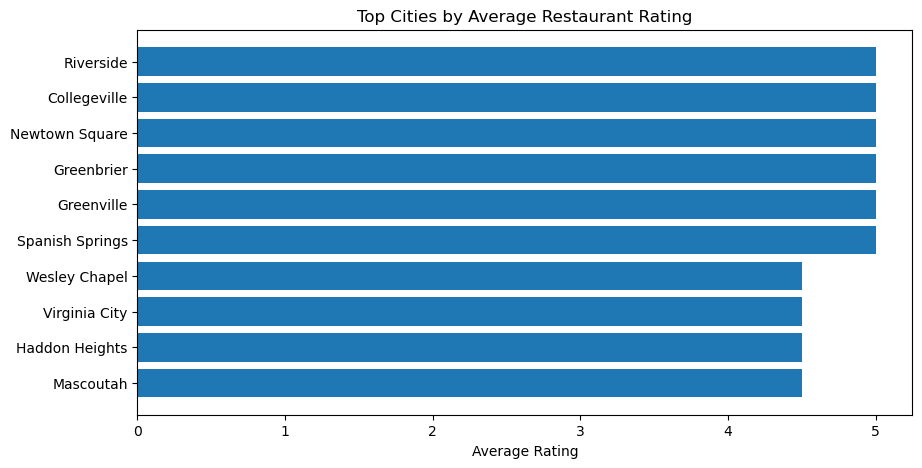

In [19]:
## Market Landscape: Geographic Patterns in Restaurant Performance

city_data = analyzer.city_performance()[:10]
cities = [c[0] for c in city_data]
ratings = [c[1] for c in city_data]

plt.figure(figsize=(10,5))
plt.barh(cities, ratings)
plt.xlabel("Average Rating")
plt.title("Top Cities by Average Restaurant Rating")
plt.gca().invert_yaxis()
plt.show()

# Market Landscape: Overall Quality Distribution on Yelp

To understand the overall performance structure of the Yelp restaurant ecosystem, we analyze the distribution of restaurant ratings.

This allows us to observe whether the market is skewed towards high-quality restaurants or dominated by mid-tier performers, and helps contextualize the competitive environment before deeper analysis.

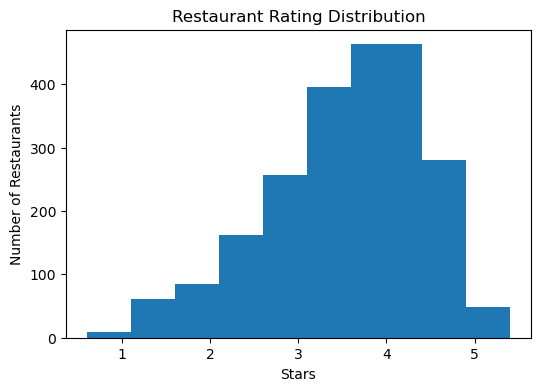

In [20]:


rating_dist = db.rating_distribution()
stars = [x[0] for x in rating_dist]
counts = [x[1] for x in rating_dist]

plt.figure(figsize=(6,4))
plt.bar(stars, counts)
plt.xlabel("Stars")
plt.ylabel("Number of Restaurants")
plt.title("Restaurant Rating Distribution")
plt.show()

## Market Landscape: Category-Level Performance Patterns
Beyond geography, the type of cuisine or restaurant category can significantly influence performance.

In this section, we analyze category-level patterns to identify which restaurant types tend to receive higher customer ratings. This helps us understand how business positioning and offerings shape restaurant outcomes.


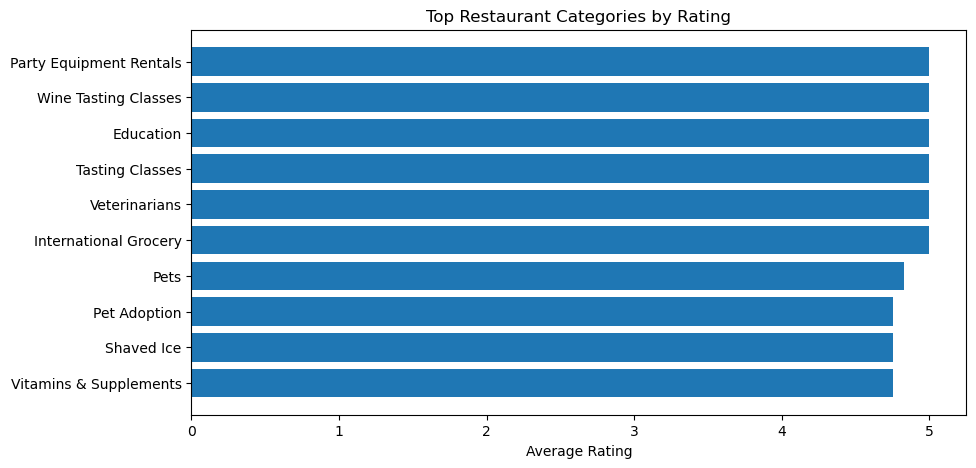

In [21]:
# ----- MARKET LANDSCAPE: Top Restaurant Categories by Rating -----

cat_data = analyzer.category_performance()[:10]
cats = [c[0] for c in cat_data]
avg = [c[1] for c in cat_data]

plt.figure(figsize=(10,5))
plt.barh(cats, avg)
plt.xlabel("Average Rating")
plt.title("Top Restaurant Categories by Rating")
plt.gca().invert_yaxis()
plt.show()


## Business Intelligence Layer: Consolidating Insights for Decision Support
After analyzing market patterns and defining algorithmic success measures, we now consolidate the system’s outputs into structured business insights.

This layer acts as a decision-support interface by aggregating:
- top performing geographies  
- best-performing restaurant categories  
- highest-success restaurants  

In [22]:
# This function aggregates key analytical outputs into a single business insight object
# It acts as a bridge between analytics results and strategic recommendations
def generate_business_insights(analyzer):
    insights = {}

    insights["top_cities"] = analyzer.recommended_cities()
    insights["top_categories"] = analyzer.category_performance()[:5]
    insights["top_restaurants"] = analyzer.top_restaurants(5)

    return insights


In [23]:
insights = generate_business_insights(analyzer)

In [24]:
print("\nRecommended Cities:")
for c in insights["top_cities"][:5]:
    print(c)

print("\nTop Categories:")
for c in insights["top_categories"]:
    print(c)


Recommended Cities:
('New Orleans', 3.74, 92)
('Tampa', 3.68, 111)
('Tucson', 3.58, 70)
('Edmonton', 3.53, 77)
('Reno', 3.53, 46)

Top Categories:
('Party Equipment Rentals', 5.0, 1)
('Wine Tasting Classes', 5.0, 1)
('Education', 5.0, 1)
('Tasting Classes', 5.0, 1)
('Veterinarians', 5.0, 1)


## Strategy Layer: Algorithmic Business Recommendation Engine
In this final analytical layer, we translate synthesized insights into a concrete strategic recommendation.

Using outputs from the success and market-performance algorithms, we identify:
- the most attractive city for restaurant performance
- the strongest performing restaurant category

In [25]:
def strategic_recommendation(analyzer):
    cities = analyzer.recommended_cities()
    categories = analyzer.category_performance()

    best_city = cities[0]
    best_category = categories[0]

    return {
        "city": best_city[0],
        "avg_city_rating": best_city[1],
        "category": best_category[0],
        "avg_category_rating": best_category[1]
    }


In [26]:
strategy = strategic_recommendation(analyzer)
strategy


{'city': 'New Orleans',
 'avg_city_rating': 3.74,
 'category': 'Party Equipment Rentals',
 'avg_category_rating': 5.0}

In [27]:
## Success Drivers: Engagement, Sentiment and Algorithms

In [28]:
!pip install textblob

## Intelligence Layer: Unstructured Review Text Analysis (Sentiment Engine)
So far, our analysis has relied only on structured attributes such as ratings, locations, and review counts.

However, a large portion of customer insight is embedded in unstructured review text.  
To capture this dimension, we build a dedicated text intelligence module that processes review content and computes sentiment signals at the business level.

In [29]:
#Text Intelligence Layer
from text_intelligence import ReviewTextAnalyzer

text_analyzer = ReviewTextAnalyzer(repo)
sentiment_scores = text_analyzer.compute_sentiments()

print("Sentiment computed for", len(sentiment_scores), "businesses")

Sentiment computed for 137 businesses


In [30]:
### Validating the Text Intelligence Layer
for b in repo.businesses[40:60]:
    print(b.name, "→", round(text_analyzer.get_sentiment(b.business_id),3))

Mike's Ice Cream → 0.42
Impasto → 0
Silver and Blue Outfitters → 0
Ricardo's Italian Cafe → 0
Crafty Crab → 0
Mahony's Po-Boys & Seafood → 0
Taqueria Los Primos → 0
The Pearl → 0
Sunset 44 Bistro → 0
Subway → 0
Papa Murphy's → 0
Nipper's Pub → 0
Golden Chopstick Chinese Restaurant → 0
Altamura → 0
Home Plate Sports Pub → 0
Santa Barbara Shellfish Company → 0.281
ALM Kainan → 0
J Sushi → 0
Chipotle Mexican Grill → 0
Cerveza Jack's → 0


## Intelligence Layer: Engagement as a Driver of Restaurant Success
Before defining a composite success metric, we analyze the relationship between customer engagement and perceived quality.

This plot explores whether restaurants with higher customer interaction (number of reviews) also tend to achieve higher ratings. This helps justify the inclusion of engagement as a core component of our success algorithm.

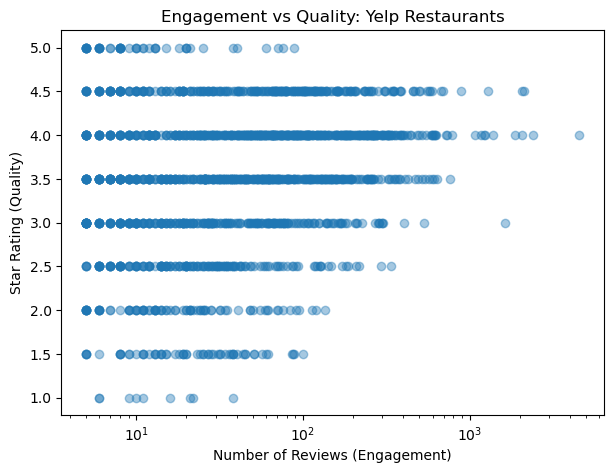

In [31]:
# ----- DRIVER ANALYSIS: Engagement vs Quality -----
ratings = [b.stars for b in repo.businesses]
reviews = [b.review_count for b in repo.businesses]

plt.figure(figsize=(7,5))
plt.scatter(reviews, ratings, alpha=0.4)
plt.xlabel("Number of Reviews (Engagement)")
plt.ylabel("Star Rating (Quality)")
plt.title("Engagement vs Quality: Yelp Restaurants")
plt.xscale("log")
plt.show()


## Strategy Layer: Market Structure and Competitive Landscape Analysis
Having defined and analyzed restaurant success, we now move from performance measurement to strategic market analysis.

In this section, we introduce a market structure engine that models:
- city–category level competition
- restaurant density
- potential market saturation

In [32]:
from market_structure import MarketStructureAnalyzer

# Initialize the market structure analyzer using the central repository
market_analyzer = MarketStructureAnalyzer(repo)

# Identify potential white-space opportunities based on competition and performance signals
market_analyzer.white_space_opportunities()


[('Tucson', 'Food Trucks', 1.09, 5),
 ('Tampa', 'Food Trucks', 1.11, 5),
 ('Philadelphia', 'Food Trucks', 1.16, 5),
 ('Tampa', 'Caribbean', 1.16, 5),
 ('Tampa', 'Latin American', 1.16, 5),
 ('Edmonton', 'Breakfast & Brunch', 1.19, 5),
 ('Tucson', 'Caterers', 1.19, 5),
 ('Tucson', 'Event Planning & Services', 1.19, 5),
 ('Clearwater', 'Sandwiches', 1.22, 5),
 ('Philadelphia', 'Bagels', 1.25, 5)]

In [33]:
#Sucess algorithm
from analytics_engine import RestaurantSuccessAnalyzer

analyzer = RestaurantSuccessAnalyzer(repo)

top = []
for b in repo.businesses:
    sent = text_analyzer.get_sentiment(b.business_id)
    score = analyzer.success_score(b, sent)
    top.append((b.name, b.city, round(score,3)))

sorted(top, key=lambda x: x[2], reverse=True)[:10]


[('Prep & Pastry', 'Tucson', 0.821),
 ('District Donuts Sliders Brew', 'New Orleans', 0.813),
 ('Padaro Beach Grill', 'Carpinteria', 0.797),
 ("Katie's Restaurant & Bar", 'New Orleans', 0.792),
 ("Mike's Ice Cream", 'Nashville', 0.784),
 ('Luke', 'New Orleans', 0.784),
 ('Siam Elephant', 'Carpinteria', 0.781),
 ('Blue Sage Vegetarian Grille', 'Southampton', 0.78),
 ('The Cuban Sandwich Shop', 'Indianapolis', 0.78),
 ('Coffeebar', 'Reno', 0.777)]

## Intelligence Layer: Distribution of Algorithmic Success Scores
After defining a composite success metric that integrates ratings, engagement, and customer sentiment, we analyze how this success score is distributed across restaurants.

This visualization helps validate whether the algorithm meaningfully differentiates high-performing restaurants from the broader market and reveals how concentrated success is within the ecosystem.


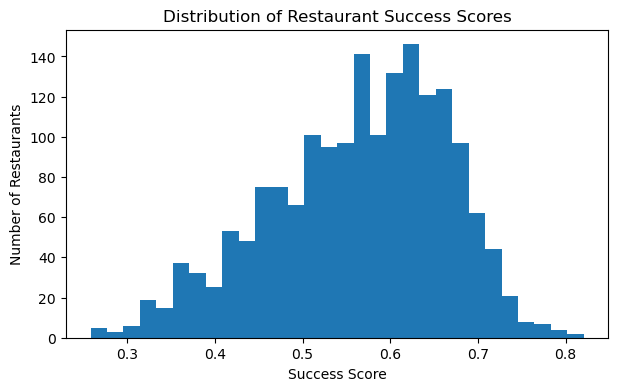

In [34]:
scores = []

# Compute success scores for all restaurants by combining:
# - star ratings (quality)
# - review counts (engagement)
# - review sentiment (customer language)
for b in repo.businesses:
    s = analyzer.success_score(b, text_analyzer.get_sentiment(b.business_id))
    scores.append(s)

# Visualize the distribution of algorithmic success scores
plt.figure(figsize=(7,4))
plt.hist(scores, bins=30)
plt.xlabel("Success Score")
plt.ylabel("Number of Restaurants")
plt.title("Distribution of Restaurant Success Scores")
plt.show()


## Live Demo: End-to-End System Output
This section demonstrates the complete functioning of the Yelp Business Intelligence System.

We execute the full analytics pipeline to:
- extract key business insights
- generate strategic recommendations
- and showcase how computing systems can support data-driven decision-making.

In [35]:
# Generate consolidated business insights
insights = generate_business_insights(analyzer)

# Generate strategic recommendation
strategy = strategic_recommendation(analyzer)

print("===== KEY BUSINESS INSIGHTS =====\n")

print("Top Performing Cities:")
for c in insights["top_cities"][:5]:
    print(c)

print("\nTop Performing Categories:")
for c in insights["top_categories"]:
    print(c)

print("\nTop Restaurants by Success Score:")
for b, score in insights["top_restaurants"]:
    print(b.name, "|", b.city, "| Success Score:", round(score,3))


print("\n===== STRATEGIC RECOMMENDATION =====")
print("Recommended City:", strategy["city"])
print("Average City Rating:", strategy["avg_city_rating"])
print("Recommended Category:", strategy["category"])
print("Average Category Rating:", strategy["avg_category_rating"])


===== KEY BUSINESS INSIGHTS =====

Top Performing Cities:
('New Orleans', 3.74, 92)
('Tampa', 3.68, 111)
('Tucson', 3.58, 70)
('Edmonton', 3.53, 77)
('Reno', 3.53, 46)

Top Performing Categories:
('Party Equipment Rentals', 5.0, 1)
('Wine Tasting Classes', 5.0, 1)
('Education', 5.0, 1)
('Tasting Classes', 5.0, 1)
('Veterinarians', 5.0, 1)

Top Restaurants by Success Score:
Prep & Pastry | Tucson | Success Score: 0.78
District Donuts Sliders Brew | New Orleans | Success Score: 0.779
Katie's Restaurant & Bar | New Orleans | Success Score: 0.765
Padaro Beach Grill | Carpinteria | Success Score: 0.754
Luke | New Orleans | Success Score: 0.753

===== STRATEGIC RECOMMENDATION =====
Recommended City: New Orleans
Average City Rating: 3.74
Recommended Category: Party Equipment Rentals
Average Category Rating: 5.0
